# Assignment 2


**Structure of the notebook**

> 0. Evaluate SpaCy on ConLL 2003 
  - 0.0 token-level accuracy
  - 0.1 chunk-level metrics
1. Grouping of Entities
2. Fix Segmentation Errors
>
>- Appendix A: conversion spacy2conll2003
>- Appendix B: train a **Transformer** on conll2003 and shows performances
>- Appendix C: how does point 2. (compound expansion) modify the tags?

**brief summary of the functions**

most of the functions are implemented as custom pipeline components, so the results are stored in Soc/Token attributes

    0. Evaluate SpaCy on ConLL 2003
    - option1: a custom whitespaces tokenizer is used to process the sentences from conll2003
    - option2: spacy tokenizer is used, then spacy tokens are remapped to conll tokens
    - conll_convert_pipe: takes token .ent_iob_ and .ent_type_, convert to conll format and store the result in Token._.conll2003
>
    1. Grouping of Entities
    - group_entities_pipe: takes the entities of a doc and group them by chunks, stores the result in Doc._.g_ents
>
    2. Fix Segmentation Errors
    - postprocessing_pipe: unify entities that are linked by a compound dependency, modifies Doc.ents attribute

In [ ]:
%%capture
# download spacy model
!python -m spacy download en_core_web_sm

# download conll2003 dataset
!wget -c https://github.com/esrel/NLU.Lab.2021/raw/master/src/conll2003.zip
!unzip -o ./conll2003.zip

# download conll script for chunk evaluation
!wget -c https://raw.githubusercontent.com/esrel/NLU.Lab.2021/master/src/conll.py

In [ ]:
import os
from collections import defaultdict
import pandas as pd
import numpy as np
from IPython.display import display

import spacy
from spacy.matcher import Matcher
from spacy.tokens import Token, Doc
from conll import evaluate

## **0. Evaluate spaCy NER on CoNLL 2003 data**

- Reading the data:   load dataset from files
- From spacy 2 conll: new component for nlp that convert to conll2003 format
- Two options: custom tokenizer / compact tokens
- Processing the data: use functions declared above

( instead of having a function that process one sentence at the time, we use nlp.pipe(corpus) for improved performances )

#### Reading the data

conll.py contain a function called *read_corpus_conll*.
It processes the input file similarly to *get_data* (defined below).

The only difference is that *get_data* do not include *-DOCSTART- -X- -X- O* lines (I think they were of no use for this assignment).

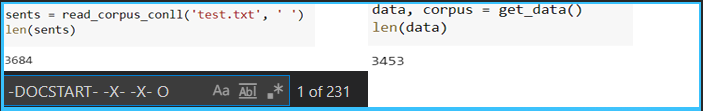



In [ ]:
# conll.py contains 'read_corpus_conll' but this works too

def get_data(train=False):
  """load conll2003 dataset
  for test.txt
  --> corpus[0] = "SOCCER - JAPAN GET LUCKY WIN , CHINA IN SURPRISE DEFEAT ."
  --> data[0]   = [('SOCCER', 'NN', 'B-NP', 'O'), ('-', ':', 'O', 'O'), ('JAPAN', 'NNP', 'B-NP', 'B-LOC'), ...]
  """
  filen = train and 'train.txt' or 'test.txt'                                 # select train/test
  assert filen in os.listdir('.'), 'Dataset: Conll2003.eng Not Found'         # checks if file is present
  with open(filen, 'r') as fin: data=fin.read()                               # read the file
  data = ''.join(data.split('-DOCSTART- -X- -X- O\n\n'))                      # removes DOCSTART lines
  data = data.split('\n\n')                                                   # split by sentences
  data = [[tuple(tok.split()) for tok in sent.split('\n')] for sent in data]  # for each sentence: split by line and then by spaces
  data = [s for s in data if len(s[0])>0]                                     # drop bad sentences
  corpus = [' '.join([s[0] for s in sent]) for sent in data]                  # define the text of a sentence as the tokens joined by a space
  return data, corpus

# data[0]   = [('SOCCER', 'NN', 'B-NP', 'O'), ('-', ':', 'O', 'O'), ('JAPAN', 'NNP', 'B-NP', 'B-LOC'), ('GET', 'VB', 'B-VP', 'O'), ('LUCKY', 'NNP', 'B-NP', 'O'), ('WIN', 'NNP', 'I-NP', 'O'), (',', ',', 'O', 'O'), ('CHINA', 'NNP', 'B-NP', 'B-PER'), ('IN', 'IN', 'B-PP', 'O'), ('SURPRISE', 'DT', 'B-NP', 'O'), ('DEFEAT', 'NN', 'I-NP', 'O'), ('.', '.', 'O', 'O')]
# corpus[0] = 'SOCCER - JAPAN GET LUCKY WIN , CHINA IN SURPRISE DEFEAT .'

#### From Spacy IOB to conll2003 format

SpaCy uses different labels from CoNNL 2003 dataset, for example PERSON is not a label used in conll, while PER is not used in spacy.

So I needed to convert them.

I excluded converting from conll to spacy because spacy's categories are more detailed, so I had to figure out how to convert from spacy to conll.

After a search on the internet I found nothing (I was hoping for spacy's [convert](https://spacy.io/api/cli#convert) function, but it just transformed my .txt in a .json...)

So, I opted for a self-made mapping. The mapping follows 2 criteria:
- the conversion must be intuitive (eg. PERSON->PER,  LOC->LOC)
- It should improve the metrics ((more in [Appendix A](https://colab.research.google.com/drive/1NMxRXwLViHGGofFFcz5Lu_DeGiAmWJwN#scrollTo=pOj3tZOPNOHn&line=3&uniqifier=1)))



In [ ]:
convert = {
  'ORG':    'ORG',
  'GPE':    'LOC',
  'LOC':    'LOC',
  'FAC':    'ORG',
  'PERSON': 'PER',
  'WORK_OF_ART':'PER',  #also 'MISC' could go
  'EVENT':  'MISC',
  'NORP':   'MISC',
  'LANGUAGE':'MISC',
  'PRODUCT':'MISC',
  'LAW':    'MISC',

  'OTHERS...':'',
}
convert = defaultdict(lambda: '', convert)

Token.set_extension("conll2003", default=None, force=True)
def conll_convert_pipe(doc:spacy.tokens.Doc) -> spacy.tokens.Doc:
  """add to each token the attribute conll2003, which contains the IOB label"""
  for tok in doc:
    if convert[tok.ent_type_] != '':
      # concatenate iob to type
      ent = tok.ent_iob_+'-'+convert[tok.ent_type_]
    else:
      # ent_iob_=='O'  or  ent_type_ converted is ''
      ent = 'O'
    tok._.conll2003 = ent
  return doc

#### Custom Tokenizer & compact tokens

OPTION 1:

spacy will probably tokenize the sentences in a different way wrt. the ground truth, so we need to change the tokenizer.

note: spacy's pipelines have been trained with tokens found by standard spacy's tokenizer. It is possible that changing the tokenizer will affect the evaluation metrics. 

OPTION 2:

after seeing the answer to Jho in Piazza, I implemented a new function that follows the instructions in that answer (use nlp tokenizer then compact tokens).

**option 2 has very slightly better results (but I like using the custom tokenizer more, so I used it in 1. and 2. too)**

In [ ]:
# OPTION 1
# idea from https://www.reddit.com/r/LanguageTechnology/comments/cibtow/testing_spacy_ner_model_on_conll_2003_corpus/
class WhitespaceTokenizer:
    def __init__(self, vocab): self.vocab = vocab
    def __call__(self, text):
        words = text.split(" ")                       # for how we defined the corpus before
        return Doc(self.vocab, words=words)


# OPTION 2
# takes docs processed by spacy and returns hyps
def compact_tokens(docs, refs):
  hyps=[]
  for doc, sent in zip(docs, refs):
    tmp, i, ent = [], 0, 'O'                           # sentence to be compacted, token index, NER tag
    for tok, _ in sent:
      remain, found = tok, False
      while (not found and i < len(doc)):
        if doc[i].text == remain:
          ent = doc[i]._.conll2003 if ent=='O' else ent
          tmp.append((tok, ent))
          found, ent = True, 'O'
          i+=1
        else:
          remain = remain[len(doc[i].text):]
          i+=1
      if not found: raise Exception('failed for sentence: '+doc.text)
    hyps.append(tmp)
  return hyps

In [ ]:
####### test compact tokens
data, corpus = get_data()
nlp = spacy.load('en')
nlp.add_pipe(conll_convert_pipe, last=True)

ref = [(t[0], t[3]) for t in data[2]]
spa = compact_tokens([nlp(corpus[2])], [ref])

print(corpus[2]); print(spa); print(ref)

AL-AIN , United Arab Emirates 1996-12-06
[[('AL-AIN', 'I-ORG'), (',', 'O'), ('United', 'B-LOC'), ('Arab', 'I-LOC'), ('Emirates', 'I-LOC'), ('1996-12-06', 'O')]]
[('AL-AIN', 'B-LOC'), (',', 'O'), ('United', 'B-LOC'), ('Arab', 'I-LOC'), ('Emirates', 'I-LOC'), ('1996-12-06', 'O')]


#### Processing The Data

cell1: these functions take a list of sentences as input and return the hypoteses

cell2: select option

cell3: load nlp, add component to nlp pipeline that add conll2003 attribute, process data

In [ ]:
# process with OPTION 1
def get_tag_prediction_1(corpus):
  """process a list of strings --> returns a list of lists
  input:  ['Hello, I am Thomas', 'other sentence']
  output: [[('Hello,', 'O'), ('I', 'O'), ('am', 'O'), ('Thomas', 'O')], [('other', 'O'), ('sentence', 'O')]]
  """
  hyps = []
  for doc in nlp.pipe(corpus):
    pred = []
    for tok in doc:
      pred.append((tok.text, tok._.conll2003))
    hyps.append(pred)
  return hyps

# process with OPTION 2
def get_tag_prediction_2(corpus, refs):
  """process docs, then uses compact_tokens"""
  docs = list(nlp.pipe(corpus))
  return compact_tokens(docs, refs)


In [ ]:
OPTION = 2               # 1-->whitespace tokenizer,   2-->compact_tokens

In [ ]:
nlp = spacy.load('en_core_web_sm')                                  # load Language
if OPTION==1: nlp.tokenizer = WhitespaceTokenizer(nlp.vocab)        # substitute tokenizer
nlp.add_pipe(conll_convert_pipe, last=True)

data, corpus = get_data(train=False)                                # load dataset

refs = [[(tok, iob) for tok, _, _, iob in sent] for sent in data]   # ground truth

if OPTION==1:
  hyps = get_tag_prediction_1(corpus)                               # predictions
else:
  hyps = get_tag_prediction_2(corpus, refs)

# example of a sentence in g_truth / prediction
print(refs[0])
print(hyps[0])

[('SOCCER', 'O'), ('-', 'O'), ('JAPAN', 'B-LOC'), ('GET', 'O'), ('LUCKY', 'O'), ('WIN', 'O'), (',', 'O'), ('CHINA', 'B-PER'), ('IN', 'O'), ('SURPRISE', 'O'), ('DEFEAT', 'O'), ('.', 'O')]
[('SOCCER', 'O'), ('-', 'O'), ('JAPAN', 'O'), ('GET', 'O'), ('LUCKY', 'O'), ('WIN', 'B-ORG'), (',', 'O'), ('CHINA', 'B-LOC'), ('IN', 'O'), ('SURPRISE', 'O'), ('DEFEAT', 'O'), ('.', 'O')]


#### 0.0 Token Level Accuracies

cell1: confusion matrix

cell2: accuracy

In [ ]:
####### confusion matrix: row-real, col-predicted
cm = defaultdict(lambda: defaultdict(lambda: 0))

for s1, s2 in zip(refs, hyps):
  for (_, real), (_, pred) in zip(s1, s2):
    cm[real][pred] += 1

# reorder columns
ord_cm = defaultdict(lambda:{})
for i in cm.keys():
  for j in cm.keys():
    ord_cm[i][j] = cm[i][j]

# print confusion matrix
df = pd.DataFrame().from_dict(ord_cm, orient='index')
display(df)

,O,B-LOC,B-PER,I-PER,I-LOC,B-MISC,I-MISC,B-ORG,I-ORG
O,37544,46,59,143,26,56,46,177,226
B-LOC,214,1201,35,8,24,20,1,123,42
B-PER,318,46,1010,40,0,18,1,157,27
I-PER,147,5,7,900,19,0,3,1,74
I-LOC,46,3,0,7,148,0,1,0,52
B-MISC,160,20,25,4,7,386,38,43,19
I-MISC,64,0,1,10,7,6,88,3,37
B-ORG,604,180,151,36,0,31,0,560,99
I-ORG,205,11,4,98,32,3,3,8,471


In [ ]:
##### Accuracy & Recall
metrics = {}
tot = df.sum().sum()

diag = pd.Series(np.diag(df), index=[df.index, df.columns])
#             correctly_classified / all_prediction          recall precision
metrics['TOTAL'] = [diag.sum().sum() / tot,                   None, None]  

for cl in df.keys():
  # correctly classified wrt. a specific class
  #        every prediction is correct, except the ones on the line/column  that are not [cl,cl]
  #         (     TRUE NEGATIVE - TRUE POSITIVE    )  + (  2*TRUE POSITIVE )
  correct  = tot - df.loc[cl,:].sum() - df.loc[:,cl].sum() + 2*df.loc[cl,cl]
  accuracy = correct / tot
  recall   = df.loc[cl,cl] / df.loc[cl,:].sum()
  precision= df.loc[cl,cl] / df.loc[:,cl].sum()
  metrics[cl] = [accuracy, recall, precision]

# avg. recall & precision
metrics['TOTAL'][1] = sum([v[1] for k,v in metrics.items() if k!='TOTAL']) / (len(metrics)-1)
metrics['TOTAL'][2] = sum([v[2] for k,v in metrics.items() if k!='TOTAL']) / (len(metrics)-1)

acc = pd.DataFrame(metrics, index=['Accuracy', 'Recall', 'Precision'])
acc.round(3)

,TOTAL,O,B-LOC,B-PER,I-PER,I-LOC,B-MISC,I-MISC,B-ORG,I-ORG
Accuracy,0.911,0.945,0.983,0.981,0.987,0.995,0.990,0.995,0.965,0.980
Recall,0.615,0.980,0.720,0.625,0.779,0.576,0.550,0.407,0.337,0.564
Precision,0.669,0.955,0.794,0.782,0.722,0.563,0.742,0.486,0.522,0.450


why are the accuracies so high???

accuracy is not well defined for a single class in multi-class classification.

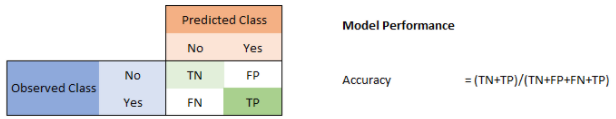

So I re-map accuracy for class X to a binary problem, where the two classes are classX and NON-classX. In conclusion the accuracies are so high because NON-classX are classified as NON-classX (eg. 'O' are classified as 'O').

I also added 2 other metrics:

- recall: TruePositive / support
- precision: TruePositive / AllPositive

#### 0.1 Chunk Level Metrics

**chunk level performance are a little worse**
eg. drop in recall for PER and ORG

In [ ]:
# compute metrics at chunk level
results = evaluate(refs, hyps)

# print results
pd_tbl = pd.DataFrame().from_dict(results, orient='index')
pd_tbl.round(decimals=3)

,p,r,f,s
PER,0.735,0.595,0.658,1617
MISC,0.725,0.547,0.623,702
ORG,0.459,0.302,0.365,1661
LOC,0.783,0.713,0.746,1668
total,0.683,0.538,0.602,5648


___
## **1. Grouping of Entities**

*group_entities_pipe* will be added as the final component of nlu pipeline. It will group entities that are in the same chunk.

After processing the corpus, we will fing our *list_of_groups* inside Doc._.g_ents attribute.

###### **group_entities_pipe custom component**

*function explaination*

    groups = {}
    for each entity:
      check if entity is inside chunk_i      (for each i)
      if yes: add entity to groups[i], break
      else: 'no chunk contained entity' and create a separate group for the entity

In [ ]:
Doc.set_extension("g_ents", default=[], force=True)

def group_entities_pipe(doc:Doc) -> Doc:
  # association chunk --> [entities]
  g_ents = defaultdict(lambda:[])
  unassigned = []

  for ent in doc.ents:
    assigned_to_chunk = False
    for i, chunk in enumerate(doc.noun_chunks):
      # get identifier of each token in the chunk
      chunk = set([t.i for t in chunk])
      if any(t.i in chunk for t in ent):
        # if entity and chunk have 1 token in common: add entity to that chunk
        g_ents[i].append(ent[0].ent_type_)
        assigned_to_chunk = True
        break
    if not assigned_to_chunk:
      unassigned.append(ent[0].ent_type_)

  g_ents =  [v for _, v in g_ents.items()]    # get only the list for the chunks
  g_ents += [[e] for e in unassigned]         # concat. unassigned entities

  doc._.g_ents = g_ents
  return doc

###### **Process Corpus**

- load nlp and modify the pipeline
- uses nlp.pipe to process the corpus
- retrieve infos from doc._.g_ents
- counts the combinations of entitiy types ( order do not count )
- prints the dicts of the counts

(order do not count) --> there are not many groups with more than 1 entity. Distinguishing them by order would cause many entry of the dict to have just 1 count, so it isn't very informative...


In [ ]:
nlp = spacy.load('en_core_web_sm')        # just to allow re-run of the cell without getting 'group_entities_pipe already added'
nlp.tokenizer = WhitespaceTokenizer(nlp.vocab)
nlp.add_pipe(group_entities_pipe, last=True)

stats = defaultdict(lambda:0)
for doc in nlp.pipe(corpus):
  for group in doc._.g_ents:
    group.sort()                          # [PERSON, LOC] == [LOC, PERSON]
    stats['-'.join(group)] += 1           # counter combinations
stats = [(k,v) for k,v in stats.items()]
stats.sort(key=lambda x: -x[1])           # order by most frequent

print("entities sharing a group:",sum([v for k,v in stats if '-' in k]),
   "   entities in a 'private' group:", sum([v for k,v in stats if '-' not in k]))
for comb, count in stats:
  print(comb, ' '*(15-len(comb)), ':', count)

entities sharing a group: 423    entities in a 'private' group: 7080
CARDINAL         : 1821
GPE              : 1269
PERSON           : 1043
ORG              : 993
DATE             : 940
NORP             : 302
MONEY            : 144
ORDINAL          : 115
TIME             : 98
CARDINAL-PERSON  : 91
PERCENT          : 86
QUANTITY         : 79
EVENT            : 62
LOC              : 51
NORP-PERSON      : 45
GPE-PERSON       : 33
ORG-PERSON       : 31
PRODUCT          : 30
CARDINAL-ORG     : 21
CARDINAL-GPE     : 20
FAC              : 19
CARDINAL-NORP    : 17
GPE-ORG          : 15
PERSON-PERSON    : 13
WORK_OF_ART      : 13
DATE-ORG         : 10
DATE-EVENT       : 9
ORG-ORG          : 9
GPE-GPE          : 9
NORP-ORG         : 8
LAW              : 8
LANGUAGE         : 7
DATE-NORP        : 6
GPE-NORP         : 5
DATE-TIME        : 5
GPE-ORDINAL      : 4
ORG-PRODUCT      : 4
DATE-PERSON      : 3
ORDINAL-PERSON   : 3
CARDINAL-GPE-PERSON  : 3
GPE-LOC          : 3
DATE-GPE         : 3
NORP-ORD

## **2. Fixing Segmentation**

we expand the entities to include tokens reached by the 'compose' dependency.
if two entities collide (after expansion they have tokens in common), they are merged into a unique entity.


Doc is the original entity, after postprocessing the span of the entity will include Hard and Drive too.

*entity[Dock]  ---postproc--> entity[Hard Drive Dock]*

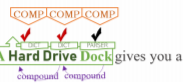



###### **postprocessing_pipe custom component**

    - we expand the entity following the outgoing compound dependency links
    - min_ and max_ tell what is the first and last token of the expanded entity.
    - prev_max tells where the previous entity ended
    - if prev_max >= min_ : they are overlapped, so we create a new entity which is the union of these two
                            should we take the type from the first or second entity? (I've chosen the second)

In [ ]:
## extend Span of entity to full chunk using .compound
def postprocessing_pipe(doc:Doc) -> Doc:
  ents = list(doc.ents)
  for _ in range(3):                                      # for how many arcs extend the entity (iter 1: ent--compound->token,   iter2: ent--compound->token--compound->token)
    extended_ents, prev_max = [], -99
    for ent in ents:
      min_, max_ = 99999, -1
      for t in ent:
        min_ = min(min_, t.i)
        max_ = max(max_, t.i)
        # INGOING LINKS
        #if t.dep_ == 'compound':
        #  min_ = min(min_, t.head.i)
        #  max_ = max(max_, t.head.i)

        # OUTGOING LINKS
        for c in t.children:
          if c.dep_ == 'compound':
            min_ = min(min_, c.i)
            max_ = max(max_, c.i)
      if prev_max >= min_:
        # if entities are now overlapping: unify them
        min_ = extended_ents[-1][0].i
        extended_ents[-1] = doc[min_:max_]
      else:
        extended_ents.append(doc[min_:max_])
      prev_max = max_
      
    for ent in extended_ents:
      # get entity type from the last tokens of the entity
      type_ = ''
      for t in reversed(list(ent)):
        type_ = convert[t.ent_type_]
        if type_ != '': break                                   # once we found a valid type break
      # re-write the chunk NER
      for i, t in enumerate(ent):
        if type_ != '':
          t._.conll2003  = 'B-'+type_ if i==0 else 'I-'+type_   # update ent chunks
        else:
          t._.conll2003  = 'O'
    ents = extended_ents
  doc.ents = ents                                               # update ents
  return doc

###### **process data**

- create our custom pipeline
- load dataset (redundant)
- use function from 0. to get the hypotesis
- use conll.evaluate to get scores

look at Appendix C to have more insights on this point

In [ ]:
nlp = spacy.load('en_core_web_sm')
nlp.tokenizer = WhitespaceTokenizer(nlp.vocab)
nlp.add_pipe(conll_convert_pipe, last=True)                         # get conll2003 labels (from point 0.)
nlp.add_pipe(postprocessing_pipe, last=True)                        # update labels & ents using compound dep 

data, corpus = get_data(train=False)

refs = [[(tok, iob) for tok, _, _, iob in sent] for sent in data]
hyps = get_tag_prediction_1(corpus) 
# compute metrics at chunk level
results = evaluate(refs, hyps)


# print results
pd_tbl = pd.DataFrame().from_dict(results, orient='index')
pd_tbl.round(decimals=3)

,p,r,f,s
PER,0.713,0.573,0.635,1617
MISC,0.712,0.534,0.610,702
ORG,0.422,0.290,0.344,1661
LOC,0.760,0.658,0.705,1668
total,0.653,0.510,0.573,5648


___

## **Appendix A**

###### How to convert from SpaCy to CoNLL2003


the cell below creates a map from the entities predicted by spacy to the ground truth. Looking at this map we can learn a good conversion

> some mappings are easy: PERSON --> PER

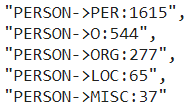

> some mappings are pretty easy: EVENT --> MISC

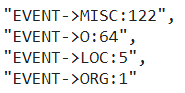

> some mappings have to be discussed: FAC --> ORG? O?

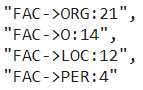

if we chose ORG we will have a better recall for organization, while if we choose O we will have a better precision.

As a rule of thumb I decided to go with the class with biggest counter, but if they are pretty close, choose the non-O one (so, FAC --> ORG)

In [ ]:
nlp = spacy.load('en_core_web_sm')

mapping = defaultdict(lambda:defaultdict(lambda:0))
spac = []
for doc in nlp.pipe(corpus):
  pred = []
  for tok in doc:
    post = '-'+tok.ent_type_ if tok.ent_type_ else ''
    ent = tok.ent_iob_+post
    pred.append((tok.text, ent))
  spac.append(pred)


for s1, s2 in zip (spac, refs):
  for (_, p1),(_, p2) in zip(s1, s2):
    p1 = p1.split('-')[1] if '-' in p1 else p1
    p2 = p2.split('-')[1] if '-' in p2 else p2
    mapping[p1][p2] += 1

final_mapping = []
for k in mapping:
  tmp = [(f'{k}->{kk}:{v}', v) for kk,v in mapping[k].items()]
  tmp.sort(key=lambda x: -x[1])
  tmp = [x[0] for x in tmp]
  final_mapping.append(tmp)

import json
print(json.dumps(final_mapping, indent=2))

[
  [
    "O->O:31393",
    "O->ORG:905",
    "O->PER:780",
    "O->LOC:535",
    "O->MISC:262"
  ],
  [
    "ORG->ORG:1019",
    "ORG->O:561",
    "ORG->PER:221",
    "ORG->LOC:200",
    "ORG->MISC:94"
  ],
  [
    "GPE->LOC:1043",
    "GPE->O:319",
    "GPE->ORG:203",
    "GPE->PER:50",
    "GPE->MISC:17"
  ],
  [
    "EVENT->MISC:122",
    "EVENT->O:64",
    "EVENT->LOC:5",
    "EVENT->ORG:1"
  ],
  [
    "CARDINAL->O:2292",
    "CARDINAL->PER:24",
    "CARDINAL->ORG:15",
    "CARDINAL->LOC:1"
  ],
  [
    "ORDINAL->O:134",
    "ORDINAL->LOC:1",
    "ORDINAL->ORG:1"
  ],
  [
    "TIME->O:256",
    "TIME->MISC:1",
    "TIME->LOC:1"
  ],
  [
    "PERSON->PER:1615",
    "PERSON->O:544",
    "PERSON->ORG:277",
    "PERSON->LOC:65",
    "PERSON->MISC:37"
  ],
  [
    "NORP->MISC:321",
    "NORP->O:63",
    "NORP->ORG:23",
    "NORP->PER:16",
    "NORP->LOC:15"
  ],
  [
    "DATE->O:1837",
    "DATE->MISC:13",
    "DATE->PER:11",
    "DATE->ORG:11",
    "DATE->LOC:2"
  ],
  [
    "FAC->OR

## **Appendix B**

Training a Neural Network for NER  (( use GPU environment, you can start from the cell below ))

(I do not get astonishing results (and no time to improve them), so I did not compare it to spaCy's *en_core_web_trf*)

    Instead of evaluating spacy models, let's train a model to see what performances we get.
    1. define a NN that uses self-attention
    2. wrap train.txt into a Dataset
    3. train and evaluate performances


In [ ]:
%%capture
# (this part of the notebook do not depend on cells above, so you can start executing it from here)
!wget -c https://github.com/esrel/NLU.Lab.2021/raw/master/src/conll2003.zip
!unzip -o ./conll2003.zip
!wget -c https://raw.githubusercontent.com/esrel/NLU.Lab.2021/master/src/conll.py

In [ ]:
from collections import defaultdict, Counter
import pandas as pd
import math
import time

import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab
from torch.utils.data import DataLoader, Dataset

from conll import evaluate

###### Model similar to a Transformer

    input.shape   = [batch_size, sentence_length_in_tokens]
    input[i,j]    = id_in_vocab for token_j in sentence_i

    output.shape  = [sentence, batch_size, class_prediction]
    output[i,j,k] = score of class_k for token_i in sentence_j

    note: sentences are cropped 'alla buona', so they aren't really sentences...
    (check https://pytorch.org/tutorials/beginner/transformer_tutorial.html to undertand better how batches are created)

    the network encodes the word_id into a vector
    couples of embeddings are then compared (self-attention)
    the result is decoded by a dense layer into the final output class score

In [ ]:
# model from: 
# https://pytorch.org/tutorials/beginner/transformer_tutorial.html

class SelfAttentionModel(nn.Module):
  def __init__(self, ntoken, nclass, ninp, nhead, nhid, nlayers, dropout=0.5):
    super(SelfAttentionModel, self).__init__()
    self.ninp = ninp
    self.encoder = nn.Embedding(ntoken, ninp)
    self.pos_encoder = PositionalEncoding(ninp, dropout)
    encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
    self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
    self.decoder = nn.Linear(ninp, nclass) # [O, B-PER, I-PER, B-LOC, ...]

    self.init_weights()

  def generate_square_subsequent_mask(self, sz):
    # self attention between every token in the sentence
    return torch.zeros((sz, sz))

  def init_weights(self):
    initrange = 0.1
    self.encoder.weight.data.uniform_(-initrange, initrange)
    self.decoder.bias.data.zero_()
    self.decoder.weight.data.uniform_(-initrange, initrange)

  def forward(self, src, src_mask):
    src = self.encoder(src) * math.sqrt(self.ninp)    # vocabulary_id --> learned_embedding
    src = self.pos_encoder(src)                       # add_position_infos
    output = self.transformer_encoder(src, src_mask)  # multi-head attentions
    output = self.decoder(output)                     # dense layer (so it's not really a transformer)
    return output

In [ ]:
# https://datascience.stackexchange.com/questions/51065/what-is-the-positional-encoding-in-the-transformer-model

class PositionalEncoding(nn.Module):
  """adds info on token position wrt sentence"""
  def __init__(self, d_model, dropout=0.1, max_len=5000):
    super(PositionalEncoding, self).__init__()
    self.dropout = nn.Dropout(p=dropout)

    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0).transpose(0, 1)
    self.register_buffer('pe', pe)

  def forward(self, x):
    x = x + self.pe[:x.size(0), :]
    return self.dropout(x)

**Dataset**

In [ ]:
class ConLL2003(Dataset):
  def __init__(self, train=False):
    self.data, self.corpus = self.get_data(train)
    self.tokenizer = lambda x: x.split()
    self.vocab = self.get_vocab()
    self.classes = ['O','B-LOC','B-PER','I-PER','I-LOC','B-MISC','I-MISC','B-ORG','I-ORG']
    self.ner_enc = {c:i for i, c in enumerate(self.classes)}
    self._cache = {}

  def __getitem__(self, idx):
    if idx in self._cache:
      x,y = self._cache[idx]
    else:
      sent, ner = self.corpus[idx], [tok[3] for tok in self.data[idx]]
      # encode sentence
      x = [self.vocab[t] for t in self.tokenizer(sent)]
      x = torch.tensor(x, dtype=torch.long)
      # encode NER
      y = [self.encode_ner(e).unsqueeze(0) for e in ner]
      y = torch.cat(y, dim=0)
      self._cache[idx] = (x,y)
    return x,y

  def __len__(self):
    return len(self.data)

  def encode_ner(self, tag):
    y = torch.tensor([0]*len(self.classes), dtype=torch.float)
    i = self.ner_enc[tag]
    y[i] = 1.
    return y

  def get_vocab(self):
    data, corpus = self.get_data(train=True)
    counter = Counter()
    for line in corpus:
        counter.update(self.tokenizer(line))
    return Vocab(counter)

  def get_data(self, train=False):
    filen = 'train.txt' if train else 'test.txt'
    with open(filen, 'r') as fin: data=fin.read()   
    data = ''.join(data.split('-DOCSTART- -X- -X- O\n\n'))   
    data = data.split('\n\n')                 
    data = [[tuple(tok.split()) for tok in sent.split('\n')] for sent in data] 
    data = [s for s in data if len(s[0])>0]   
    corpus = [' '.join([s[0] for s in sent]) for sent in data]  
    return data, corpus

**loss function**

In [ ]:
w = torch.tensor([.004, 1.,1.,1.,1.,1.,1.,1.,1.,]) # less weight to 'O'
c_entropy = nn.CrossEntropyLoss(weight=w)

def loss_fn(outputs, targets):
  """seems not to be working =\ """
  n = outputs.shape[2]                                                # number of classes
  outputs, targets = outputs.reashape(-1, n), targets.reashape(-1, n) # out[i,j] = score_of_class_j for token_i
  _, idxs = targets.max(dim=2)                                        # prediction = class with highest score
  return c_entropy(outputs, idxs)

def loss_fn(outputs, targets, n_classes=9):
  """compute the error
  classes are very unbalanced towards 'O' --> weights re-distibute the importance of the classes
  ((0.5*outputs + (outputs-targets)**2)**2) can be rewritten as  ( (1/4)*outputs**2 + MSE*outputs + MSE**2 ) --> first therm: we want low prediction in general, second term: penalize errors especially when the output activated a lot, third term: MSE**4
  """
  with torch.no_grad():
    counts  = targets.sum(dim=(0,1))
    weights = (10000/(.2+counts))**2
    weights[0] * 0.8              # little less importance to 'O'
  err = ((0.25*outputs + (outputs-targets)**2)**2).sum(dim=(0,1))
  return (weights*err).sum()

def collate(data):
  """sentences have different lengths, so they are hard to concatenate (after being ancoded into tensors)
  pytorch tutorial just concatenates everything
  then cuts sentences randomly, eg. sent1+sent2+sent3 ---> batch=[sent1sen, t2sent3]
  """
  xs = [x for x,_ in data]
  ys = [y for _,y in data]
  return (torch.cat(xs), torch.cat(ys, dim=0))

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
def set_rand_seed(s=1):
  torch.manual_seed(s)
  torch.cuda.manual_seed(s)
  torch.cuda.manual_seed_all(s)

**Training**

In [ ]:
tk_s = 25  # tokens in a sample

set_rand_seed()
dataset = ConLL2003(train=True)
train_loader = DataLoader(dataset, 256, True, collate_fn=collate)
n_class = len(dataset.classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SelfAttentionModel(ntoken=len(dataset.vocab), nclass=n_class, ninp=128, nhead=4, nhid=128, nlayers=2, dropout=.2).to(device)
model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.21, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, gamma=0.8)

start = time.time()

print(f'----------------- starting epoch 0 ---- n. params={sum([p.numel() for p in model.parameters()])}  ------------------')
best_model, best_loss = None, 1e20
for e in range(250):
  tot_loss, cc, lines = 0, 0, 0
  for inputs, targets in train_loader:
    # cast input & target to the right shape
    to_rem  = inputs.shape[0] % tk_s
    lines += inputs.shape[0]
    if inputs.shape[0] <= to_rem: continue
    if to_rem:
      inputs, targets = inputs[:-to_rem], targets[:-to_rem]
    inputs  = inputs.reshape(-1,tk_s).transpose(0,1).to(device)
    targets = targets.reshape(-1,tk_s, n_class).transpose(0,1).to(device)  #(tk_s, N, len_classes)
    src_mask = model.generate_square_subsequent_mask(tk_s).to(device)

    #predict
    outputs = model(inputs, src_mask)

    # backward
    loss = loss_fn(outputs, targets)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
    optimizer.step()
    optimizer.zero_grad()

    # stats
    tot_loss, cc = loss.item(), cc+outputs.shape[1]    
  
  if e%10==0: print(f'------------ Epoch {e} {" "*(15-len(str(e)))} loss={tot_loss/cc:.4E}  (lr={get_lr(optimizer):.2E})------------')
  if tot_loss/cc < best_loss:
    best_model = model.state_dict()
    best_loss  = tot_loss/cc
  scheduler.step()

#model.load_state_dict(best_model)
print(f'\nTRAINING TOOK {time.time()-start} SECONDS')
print(f'best model loss = {best_loss:.2E}')

----------------- starting epoch 0 ---- n. params=3224329  ------------------
------------ Epoch 0                loss=1.9224E+04  (lr=2.10E-01)------------
------------ Epoch 10               loss=6.7940E+03  (lr=1.68E-01)------------
------------ Epoch 20               loss=3.7158E+03  (lr=1.34E-01)------------
------------ Epoch 30               loss=2.9682E+03  (lr=1.08E-01)------------
------------ Epoch 40               loss=2.2817E+03  (lr=8.60E-02)------------
------------ Epoch 50               loss=3.1482E+03  (lr=6.88E-02)------------
------------ Epoch 60               loss=2.1715E+03  (lr=5.51E-02)------------
------------ Epoch 70               loss=1.7949E+03  (lr=4.40E-02)------------
------------ Epoch 80               loss=1.6667E+03  (lr=3.52E-02)------------
------------ Epoch 90               loss=2.3338E+03  (lr=2.82E-02)------------
------------ Epoch 100              loss=1.6454E+03  (lr=2.25E-02)------------
------------ Epoch 110              loss=2.3741E+03  

In [ ]:
emb2class = {i:c for c,i in dataset.ner_enc.items()}   # dataset is a global variable
def embed_to_tag(outputs):
  outputs = outputs.to('cpu')
  hyps = []
  for sent in range(outputs.shape[1]):
    sent = outputs[:, sent, :].reshape(-1, len(emb2class))
    tmp = []
    for pred in sent:
      _, i = torch.max(pred, dim=0)
      tmp.append(emb2class[i.item()])
    hyps.append(tmp)
  return hyps


###### **Evaluating**

In [ ]:
on_test_set = True      # False uses training set (which obviously has better performances)

In [ ]:
hyps = []
test_loader = DataLoader(ConLL2003(train=not on_test_set), 1, False)

model.eval()
with torch.no_grad():
  for inputs, targets in test_loader:
    inputs = inputs.transpose(0,1).to(device)
    targets = targets.transpose(0,1).to(device)
    src_mask = model.generate_square_subsequent_mask(inputs.shape[0]).to(device)

    #predict
    outputs = model(inputs, src_mask)
    hyps += embed_to_tag(outputs)

In [ ]:
data, corpus = get_data(train=not on_test_set)

refs = [[(tok, iob) for tok, _, _, iob in sent] for sent in data]
hyps = [[(tok, iob) for (tok, _), iob in zip(ref, sent)] for ref, sent in zip(refs, hyps)]

results = evaluate(refs, hyps)

# print results
pd_tbl = pd.DataFrame().from_dict(results, orient='index')
pd_tbl.round(decimals=3)

,p,r,f,s
PER,0.456,0.288,0.353,1617
MISC,0.635,0.660,0.647,702
ORG,0.557,0.481,0.516,1661
LOC,0.753,0.779,0.766,1668
total,0.616,0.536,0.573,5648


###### Final Thoughts

The model has quite satisfying performances.

we get good results because:
- training and test set are very similar, probably if we had a testset about financial news or technical stuff we'd have got worse performances

we get bad results because:
- PERSON identification task has poor performances, but learning names shouldn't be an hard task. This mean that the system do not recognize names it hasn't seen before (poor generalization). Anyway the real problem is that the training set is too small, if we had 10x more sentences we would have many more names our network could learn from (the same goes for all the other tasks).

- we could have added also POS infos to the output (multi-task learning) and see if it was useful

In [ ]:
print(refs[0], '\n', hyps[0], '\n','_'*80,'\n\n')
cm = defaultdict(lambda: defaultdict(lambda: 0))

for s1, s2 in zip(refs, hyps):
  for (_, real), (_, pred) in zip(s1, s2):
    cm[real][pred] += 1

# reorder columns
ord_cm = defaultdict(lambda:{})
for i in cm.keys():
  for j in cm.keys():
    ord_cm[i][j] = cm[i][j]

# print confusion matrix
df = pd.DataFrame().from_dict(ord_cm, orient='index')

print('rows: real,    column: prediction')
display(df)

[('SOCCER', 'O'), ('-', 'O'), ('JAPAN', 'B-LOC'), ('GET', 'O'), ('LUCKY', 'O'), ('WIN', 'O'), (',', 'O'), ('CHINA', 'B-PER'), ('IN', 'O'), ('SURPRISE', 'O'), ('DEFEAT', 'O'), ('.', 'O')] 
 [('SOCCER', 'O'), ('-', 'O'), ('JAPAN', 'O'), ('GET', 'O'), ('LUCKY', 'O'), ('WIN', 'O'), (',', 'O'), ('CHINA', 'I-ORG'), ('IN', 'O'), ('SURPRISE', 'O'), ('DEFEAT', 'O'), ('.', 'O')] 
 ________________________________________________________________________________ 


rows: real,    column: prediction


,O,B-LOC,B-PER,I-PER,I-LOC,B-MISC,I-MISC,B-ORG,I-ORG
O,37965,19,22,46,17,60,50,57,87
B-LOC,230,1310,3,5,23,15,2,64,16
B-PER,716,20,706,135,6,10,0,14,10
I-PER,735,11,57,321,3,3,1,14,11
I-LOC,56,19,0,0,159,3,1,1,18
B-MISC,169,13,3,5,1,474,12,22,3
I-MISC,59,0,1,0,2,13,136,1,4
B-ORG,453,208,10,2,5,37,11,858,77
I-ORG,231,39,2,8,29,8,13,68,437


## **Appendix C**

exploring the changes made by 2. (expanding entities)

how is expansion affecting the labels?

In [ ]:

_, corpus = get_data(train=False)    

##### Default Prediction
nlp = spacy.load('en_core_web_sm')           
nlp.tokenizer = WhitespaceTokenizer(nlp.vocab)   
nlp.add_pipe(conll_convert_pipe, last=True)
start = get_tag_prediction_1(corpus)                               

##### With Expansion
nlp = spacy.load('en_core_web_sm')
nlp.tokenizer = WhitespaceTokenizer(nlp.vocab)
nlp.add_pipe(conll_convert_pipe, last=True)   
nlp.add_pipe(postprocessing_pipe, last=True)    # update conll2003 attribute
after = get_tag_prediction_1(corpus)

# show conf_matrix
print('rows: without expansion,    column: with expansion')
cm = defaultdict(lambda: defaultdict(lambda: 0))
for s1, s2 in zip(start, after):
  for (_, real), (_, pred) in zip(s1, s2):
    cm[real][pred] += 1
ord_cm = defaultdict(lambda:{})
for i in cm.keys():
  for j in cm.keys():
    ord_cm[i][j] = cm[i][j]
display(pd.DataFrame().from_dict(ord_cm, orient='index'))


# if df.loc['O', 'I-LOC'] == 26, it means that:
#---> 26 'O' became 'I-LOC' after the expansions

rows: without expansion,    column: with expansion


,O,B-ORG,B-LOC,I-LOC,B-MISC,I-MISC,I-ORG,B-PER,I-PER
O,39159,1,1,26,0,10,35,2,12
B-ORG,0,1124,0,0,0,0,15,0,0
B-LOC,0,0,1433,11,0,0,0,0,0
I-LOC,0,0,0,251,0,0,0,0,0
B-MISC,0,0,0,0,524,3,0,0,0
I-MISC,0,0,0,0,0,167,0,0,0
I-ORG,0,1,0,0,0,0,1099,0,0
B-PER,0,0,0,0,0,0,0,1115,190
I-PER,0,0,0,0,0,0,0,1,1255
